final text_encoder_type: bert-base-uncased


[09/24/2025-22:11:18] [TRT] [W] WARNING The logger passed into createInferRuntime differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.
[09/24/2025-22:11:18] [TRT] [W] WARNING The logger passed into createInferRuntime differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.
[09/24/2025-22:11:18] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[09/24/2025-22:11:18] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure corr

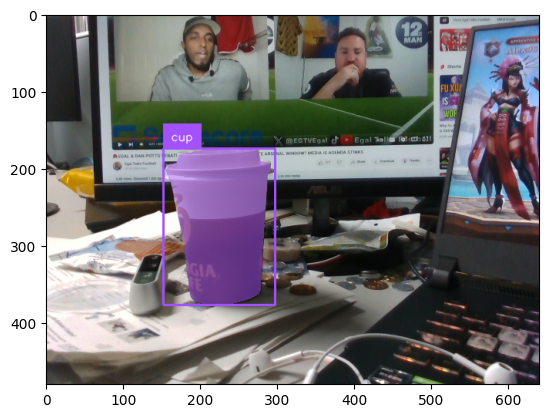

In [ ]:
from groundingdino.util.inference import Model
from nanosam.utils.predictor import Predictor
import cv2
import PIL
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np

IMAGE = "../io/images/coffee_cup.png"
OUT_IMAGE = "../io/images/annotated_bottle.png"
TEXT_PROMT = "bottle . coffee . cup . keyboard . glasses . fox . camera"

# image = cv2.imread(IMAGE)
pil_image = PIL.Image.open(IMAGE).convert("RGB")
cv_image = np.array(pil_image)

# load gdino
gdino = Model(
    model_checkpoint_path="../GroundingDINO/weights/groundingdino_swinb_cogcoor.pth",
    model_config_path="../GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py"
)

# detect bbox
bboxes, labels = gdino.predict_with_caption(
    image=cv_image,
    caption=TEXT_PROMT
)

# load nanosam
sam_predictor = Predictor(
    image_encoder_engine="../nanosam/data/resnet18_image_encoder.engine",
    mask_decoder_engine="../nanosam/data/mobile_sam_mask_decoder.engine"
)
sam_predictor.set_image(pil_image)

def bbox2points(bbox):
    points = np.array([
        [bbox[0], bbox[1]],
        [bbox[2], bbox[3]]
    ])

    point_labels = np.array([2, 3])

    return points, point_labels

n_bboxes = len(bboxes)
np_masks = []
for i in range(n_bboxes):
    # get binary mask
    points, point_labels = bbox2points(bboxes[i].xyxy[0])
    mask, _, _ = sam_predictor.predict(points, point_labels)
    binary_mask = (mask[0, 0] > 0).detach().cpu().numpy() # True/False mask, shape: (H, W)
    ys, xs = np.where(binary_mask)
    print(f"binary mask: {binary_mask.shape}, {binary_mask}")
    print(f"ys: {len(ys)}, {ys}, xs: {len(xs)} {xs}")
    np_masks.append(binary_mask[np.newaxis, :, :]) # (1, H, W)

np_masks_concat = np.concatenate(np_masks, axis=0) # (N, H, W)
sv_masks = sv.Detections(
    xyxy=bboxes.xyxy,
    mask=np_masks_concat
)

# visualize
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
out_image = box_annotator.annotate(scene=pil_image.copy(), detections=bboxes)
out_image = label_annotator.annotate(scene=out_image, detections=bboxes, labels=labels)
out_image = mask_annotator.annotate(scene=out_image, detections=sv_masks)
plt.imshow(out_image)

# PCA

In [ ]:
from sklearn.decomposition import PCA
import cv2
import PIL
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np
import os
import yaml
from utils import load_models, realsense_setup

### Config ###
# =========================================
IMAGE_DIR = "../io/images" # saved image dir
TEST_IMAGE = "../io/images/coffee_cup.png"
OUT_IMAGE = "../io/images/annotated_bottle.png"
TEXT_PROMT = "bottle . coffee . cup . keyboard . glasses . fox . camera"
GDINO_CHECKPOINT = "../GroundingDINO/weights/groundingdino_swinb_cogcoor.pth"
GDINO_CONFIG = "../GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py" 
SAM_IMAGE_ENCODER = "../nanosam/data/resnet18_image_encoder.engine"
SAM_MASK_DECODER = "../nanosam/data/mobile_sam_mask_decoder.engine"
## Realsense ##
pipeline, config, colorizer = realsense_setup()
## Camera intrinsics ##
with open("../io/config/camera_intrinsics.yml") as f:
    config = yaml.safe_load(f)
_intrinsics = config["realsense1"]
_fx = _intrinsics["fx"]
_fy = _intrinsics["fy"]
_cx = _intrinsics["cx"]
_cy = _intrinsics["cy"]
_depth_scale = _intrinsics["depth_scale"]
# =========================================

### Load models ### 
gdino_model, sam_predictor = load_models(gdino_checkpoint=GDINO_CHECKPOINT,
                                        gdino_config=GDINO_CONFIG,
                                        sam_image_encoder=SAM_IMAGE_ENCODER,
                                        sam_mask_decoder=SAM_MASK_DECODER)

def bbox2points(bbox):
    points = np.array([
        [bbox[0], bbox[1]],
        [bbox[2], bbox[3]]
    ])

    point_labels = np.array([2, 3])

    return points, point_labels

def get_pcl_from_mask(binary_mask, depth_image):
    """Get 3D point cloud within a given mask.
    
    Args
    ----
    binary_mask: np.ndarray
        detected object mask, shape (H, W), dtype=bool
    depth_image: np.ndarray
        depth image, shape (H, W), dtype=float32, unit in meters

    Returns
    -------
    pcl: np.ndarray
        point cloud within the mask, shape (N, 3), dtype=float32, unit in meters. 
    """
    ### Get masked pixels depth ###
    # ys and xs are 1D array of pixel coordinates, len(ys) = len(xs) = number of pixels in the mask.
    # depth is 1D array, len(depth) = len(ys) = len(xs) = number of pixels in the mask.
    ys, xs = np.where(binary_mask) # Get masked pixel coordinates
    depth = depth_image[ys, xs] * _depth_scale # Get depth

    pcl = np.zeros((len(xs), 3), dtype=np.float32) # (N, 3) = (len(xs), 3)
    pcl[:, 0] = (xs - _cx) * depth / _fx
    pcl[:, 1] = (ys - _cy) * depth / _fy
    pcl[:, 2] = depth
    return pcl

def get_annotate_image(image, bboxes, labels, sv_masks):
    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    out_image = box_annotator.annotate(scene=image.copy(), detections=bboxes)
    out_image = label_annotator.annotate(scene=out_image, detections=bboxes, labels=labels)
    out_image = mask_annotator.annotate(scene=out_image, detections=sv_masks)
    plt.imshow(out_image)
    
    return out_image


# start streaming
pipeline.start(config)
frame_count = 0
try:
    while True:
        # Get depth and color image
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()
        if not color_frame or not depth_frame:
            continue
        
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())

        cv2.imshow('Camera On', color_image)

        # detect bbox using gdino
        bboxes, labels = gdino_model.predict_with_caption(
            image=color_image,
            caption=TEXT_PROMT
        )

        # detect mask using nanosam
        sam_predictor.set_image(PIL.Image.fromarray(color_image).convert("RGB"))

        n_bboxes = len(bboxes)
        np_masks = []
        pcl_list = []

        for i in range(n_bboxes):
            points, point_labels = bbox2points(bboxes[i].xyxy[0])
            mask, _, _ = sam_predictor.predict(points, point_labels)
            binary_mask = (mask[0, 0] > 0).detach().cpu().numpy() # True/False mask, shape: (H, W)
            pcl = get_pcl_from_mask(binary_mask, depth_image)
            pcl_list.append(pcl)
            np_masks.append(binary_mask[np.newaxis, :, :]) # (1, H, W)

        # concate all masks for visualization
        np_masks_concat = np.concatenate(np_masks, axis=0) # (N, H, W)
        sv_masks = sv.Detections(
            xyxy=bboxes.xyxy,
            mask=np_masks_concat
        )

        ### Handling key signals ###
        # ========================
        key = cv2.waitKey(1) & 0xFF # Get key every 1ms
        # Press 'q' to exit
        if key == ord('q'):
            break
        # Press 's' to save images
        elif key == ord('s'):
            color_path = os.path.join(IMAGE_DIR, f"color_{frame_count:04d}.png")
            depth_path = os.path.join(IMAGE_DIR, f"depth_{frame_count:04d}.png")
            cv2.imwrite(color_path, color_image)
            cv2.imwrite(depth_path, depth_image)
            print(f"[INFO] Saved color to {color_path} and depth to {depth_path}")
            frame_count += 1
        # ========================

finally:
    # Stop streaming
    pipeline.stop()
    cv2.destroyAllWindows()

        # for i, box in enumerate(detections.xyxy):
        #     x1, y1, x2, y2 = map(int, box)

        #     # Draw bounding box
        #     cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        #     cv2.putText(annotated_image, labels[i], (x1, y1-10),
        #                 cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)



        #     # PCA for orientation
        #     pca = PCA(n_components=3)
        #     pca.fit(points)
        #     centroid = np.mean(points, axis=0)
        #     orientation = pca.components_

        #     # Draw centroid
        #     u_c = int(centroid[0] * fx / centroid[2] + cx)
        #     v_c = int(centroid[1] * fy / centroid[2] + cy)
        #     cv2.circle(annotated_image, (u_c, v_c), 5, (0, 0, 255), -1)

        #     # Draw PCA axes
        #     axes_colors = [(0,0,255), (0,255,0), (255,0,0)]  # X=red, Y=green, Z=blue
        #     for j in range(3):
        #         axis_end = centroid + orientation[j] * AXIS_LENGTH
        #         u_e = int(axis_end[0] * fx / axis_end[2] + cx)
        #         v_e = int(axis_end[1] * fy / axis_end[2] + cy)
        #         cv2.line(annotated_image, (u_c, v_c), (u_e, v_e), axes_colors[j], 2)

        # pipeline.stop()

# =========================
# Save annotated image
# =========================
cv2.imwrite(OUT_IMAGE, out_image)
print(f"✅ Annotated image with PCA axes saved at {OUT_IMAGE}")

final text_encoder_type: bert-base-uncased


[09/25/2025-00:09:04] [TRT] [W] WARNING The logger passed into createInferRuntime differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.


RuntimeError: No device connected

In [4]:
depth_image = cv2.imread("../io/images/bottle_depth.png")
# print(depth_image.shape, depth_image)
x = np.where(depth_image>0)
print(x)

(array([  0,   0,   0, ..., 479, 479, 479]), array([  0,   0,   0, ..., 639, 639, 639]), array([0, 1, 2, ..., 0, 1, 2]))
